In [26]:
import os
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('./atnf_all_old.csv', sep=";", header=0, skiprows=[1])
df = df.drop('Unnamed: %d' % (len(df.columns) - 1), axis=1)

df_atnf_binary = pd.read_csv(
    "/Users/abubakribrahim/Desktop/observations/scripts/pdot_daigram/atnf_binary.csv", delimiter=";", header=[0, 1])

# Display the first few rows of the DataFrame
print(df.head())
print(df_atnf_binary.head())

# Replace '*' with NaN and convert columns to float
for column in ["P0", "P1"]:
    df[column] = df[column].replace('*', np.nan)
    df[column] = pd.to_numeric(df[column], errors='coerce')

df_atnf_binary = df_atnf_binary[~df_atnf_binary["P0"]["(s)"].isin(['NAN'])]
df_atnf_binary = df_atnf_binary[~df_atnf_binary["P1"]["(s/s)"].isin(['NAN'])]

P_binary = df_atnf_binary["P0"]["(s)"].to_numpy().astype(float)
Pdot_binary = df_atnf_binary["P1"]["(s/s)"].to_numpy().astype(float)

# Ensure the columns are properly handled
df['PSR'] = df['PSR'].fillna('').astype(str)
df['ASSOC'] = df['ASSOC'].fillna('').astype(str)

# Initialize flags for different types of pulsars
flag_axp = df['PSR'].str.contains('AXP', na=False)
flag_xins = df['PSR'].str.contains('XINS', na=False)
flag_snr = df['ASSOC'].str.contains('SNR', na=False)

# Flag for valid pulsars with P0 and P1 values
flag_pulsar = (df["P0"] > 0.0) & (df["P1"] > 0.0)


# Combine flags with valid pulsar flag
flag_axp = flag_pulsar & flag_axp
flag_xins = flag_pulsar & flag_xins
flag_snr = flag_pulsar & flag_snr
flag_binary = flag_pulsar & flag_binary

version_label = 'ATNF Pulsar Catalog v2.2 (%d pulsars)' % len(df)
print(version_label)
print(df.head())
print(df[flag_binary].head())

   #        NAME        P0        P1 BINARY  \
0  1  J0002+6216  0.115364  5.97e-15      *   
1  2  J0006+1834  0.693748  2.10e-15      *   
2  3  J0007+7303  0.315873  3.60e-13      *   
3  4    J0011+08  2.552870         *      *   
4  5  J0012+5431  3.025301  1.28e-16      *   

                                      ASSOC           PSR  
0  GRS:4FGL_J0002.8+6217[aab+22],XRS:1XSPS_    HE[wcp+18]  
1                                         *             *  
2  GRS:4FGL_J0007.0+7303[aab+22],XRS:RX_J00  NRAD[aab+22]  
3                                         *             *  
4                                         *  RRAT[cwp+17]  
                   #        NAME        P0         P1  \
  Unnamed: 0_level_1        name       (s)      (s/s)   
0                  1  J0023+0923  0.003050   1.14e-20   
1                  2   B0021-72E  0.003536   9.85e-20   
2                  3   B0021-72H  0.003210  -1.83e-21   
3                  4   B0021-72I  0.003485  -4.59e-20   
4              

In [27]:
import matplotlib.pyplot as plt

xmin = 1e-3
xmax = 1e+2
ymin = 1e-21
ymax = 1e-9

plt.style.use('https://raw.githubusercontent.com/tenoto/macsettings/master/ppdot.mplstyle')
plt.rcParams['xtick.major.pad'] = 10.0

def plot_background(flag_landscape=False,flag_text=True):
  fig, ax = plt.subplots()

  # --- Set Magnetic Field ---
  # http://www.atnf.csiro.au/research/pulsar/psrcat/psrcat_nradlp.html?type=normal&highlight=name#name
  # Bsurf = 3.2e+19 (P Pdot)^0.5
  for Bsurf in [1e+11,1e+12,1e+13,1e+14,1e+15]: # G
    x = np.logspace(np.log10(xmin),np.log10(xmax),20)
    y = (Bsurf/3.2e+19)**2 / x
    plt.plot(x,y,linestyle="--",c="#3090C7")
    x_pivot = 12.0
    if Bsurf >= 1e+12 and flag_text:
      if flag_landscape:
        ax.text(x_pivot,0.9*(Bsurf/3.2e+19)**2/x_pivot, r'$10^{%d}$ G' % (np.log10(Bsurf)), horizontalalignment='left',verticalalignment='center',
          color="#3090C7", fontsize=20, rotation=-15)
      else:
        ax.text(x_pivot,0.9*(Bsurf/3.2e+19)**2/x_pivot, r'$10^{%d}$ G' % (np.log10(Bsurf)), horizontalalignment='left',verticalalignment='center',
          color="#3090C7", fontsize=25, rotation=-30)

  Bsurf = 4.4e+13
  x = np.logspace(np.log10(xmin),np.log10(xmax),20)
  y = (Bsurf/3.2e+19)**2 / x
  plt.plot(x,y,linestyle="-",linewidth=2,c="#3090C7")
  x_pivot = 12.0
  if flag_text:
    if flag_landscape:
      ax.text(x_pivot, 1.1*(Bsurf/3.2e+19)**2/x_pivot, r'$B$cr' % (np.log10(Bsurf)), horizontalalignment='left',verticalalignment='center',color="#3090C7",fontsize=20, rotation=-10)
    else:
      ax.text(x_pivot, 1.1*(Bsurf/3.2e+19)**2/x_pivot, r'$B$cr' % (np.log10(Bsurf)), horizontalalignment='left',verticalalignment='center',color="#3090C7",fontsize=25, rotation=-30)

  # --- Set Age ---
  # http://www.atnf.csiro.au/research/pulsar/psrcat/psrcat_nradlp.html?type=normal&highlight=name#name
  # Age = P / 2Pdot
  for age in [0.1e+3, 10e+3, 1e+6, 100e+6]: #yr
    x = np.logspace(np.log10(xmin),np.log10(xmax),20)
    y = 0.5 * x / (age * 365. * 24. * 60.0**2)
    plt.plot(x,y,linestyle="--", c="#EE9A4D")

    x_pivot = 0.0020
    if (age/1e+3) >= 1000:
      text = r'$%d$ Myr' % (age/1e+6)
    elif (age/1e+3) < 1.0:
      text = r'$%.1f$ kyr' % (age/1e+3)
    else:
      text = r'$%d$ kyr' % (age/1e+3)
    if flag_text:
      if flag_landscape:
        ax.text(x_pivot, 4.3* 0.5 * x_pivot / (age * 365. * 24. * 60.0**2),
          text, color="#EE9A4D", fontsize=20, rotation=13,
          horizontalalignment='left',verticalalignment='center')
      else:
        ax.text(x_pivot, 4.3* 0.5 * x_pivot / (age * 365. * 24. * 60.0**2),
          text, color="#EE9A4D", fontsize=25, rotation=28,
          horizontalalignment='left',verticalalignment='center')

  # --- Set Lsd ---
  # Enoto et al., 2017
  # Lsd = 3.9e+35 erg/s * (Pdot/1e+11) * (P/1sec)^-3
  for Lsd in [1e+31, 1e+33, 1e+35, 1e+37]:
    x = np.logspace(np.log10(xmin),np.log10(xmax),20)
    y = (Lsd/3.9e+35) * x**3.0 * 1e-11
    plt.plot(x,y,linestyle="--", c="#8D38C9")

    x_pivot = 1e-2
    if flag_text:
      if flag_landscape:
        ax.text(x_pivot, 40.0*(Lsd/3.9e+35) * x_pivot**3.0 * 1e-11,
         r'$10^{%d}$ erg s$^{-1}$' % (np.log10(Lsd)),
         horizontalalignment='left',  verticalalignment='center',
         color="#8D38C9", fontsize=20, rotation=43)
      else:
        ax.text(x_pivot, 40.0*(Lsd/3.9e+35) * x_pivot**3.0 * 1e-11,
         r'$10^{%d}$ erg s$^{-1}$' % (np.log10(Lsd)),
         horizontalalignment='left',  verticalalignment='center',
         color="#8D38C9", fontsize=25, rotation=60)

  # --- Death Line
  # 4 log B - 7.5 log P = 49.3
  # Chen 1993; # Zhang 2000
  #for period in [0.001, 100.0]:
  #	pdot = 10**( 2 * math.log10( period ) - 16.52 )
  #	graphDeathLine.SetPoint(i, period, pdot)

  ### Chen and Ruderman 1993
  ### http://adsabs.harvard.edu/abs/1993ApJ...402..264C
  ### 4 log B - 6.5 log P = 45.7 (Eq. 8)
  ### 4 log B - 7.5 log P = 49.3 (Eq. 6)

  x = np.logspace(np.log10(xmin),np.log10(xmax),20)
  y = 10**(2*np.log10(x)-16.52)
  plt.plot(x,y,linestyle="-", linewidth=2, c="#FFA500")

  #ax.set_title(version_label,fontsize=20)
  ax.grid(True,linestyle='--')
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)
  ax.set_xlabel('Period (s)',fontsize=26,labelpad=12)
  ax.set_ylabel('Period Derivative (s s$^{-1}$)',fontsize=26,labelpad=12)
  ax.legend(loc='lower right',scatterpoints=1,fontsize=20)

  return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'serif'" not found.
findfont: Font family "'se

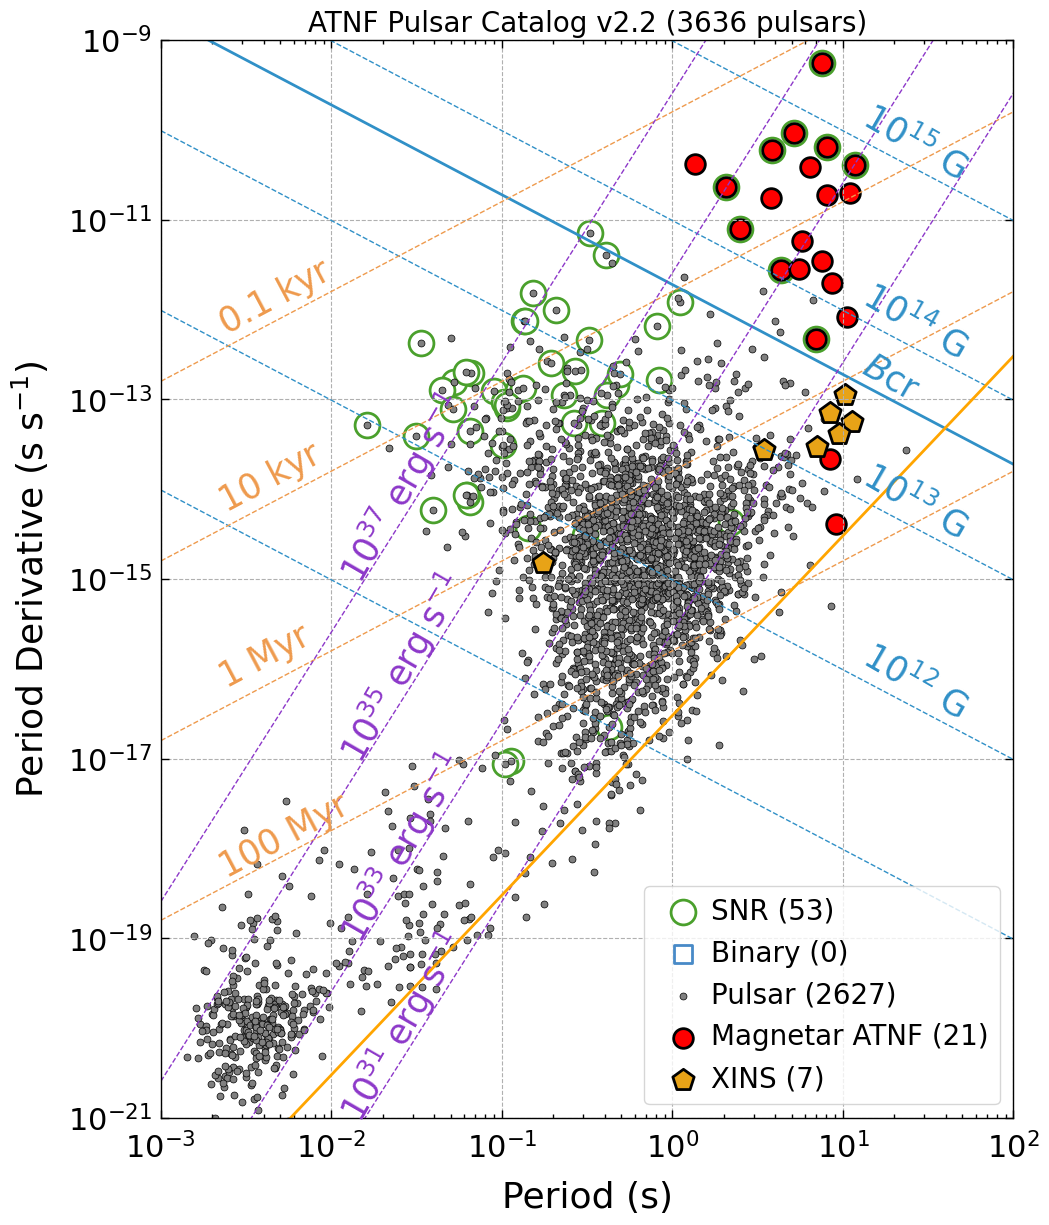

In [28]:
fig, ax = plot_background()

ax.scatter(df["P0"][flag_snr],df["P1"][flag_snr],
           label='SNR (%d)' % sum(flag_snr),
           marker='o',edgecolors='#4AA02C',c="white",linewidth=2,s=320)
ax.scatter(df["P0"][flag_binary],df["P1"][flag_binary],
           label='Binary (%d)' % sum(flag_binary),
           marker='s',edgecolors='#488AC7',c="white",linewidth=2,s=150)
ax.scatter(df["P0"][flag_pulsar],df["P1"][flag_pulsar],
           label='Pulsar (%d)' % sum(flag_pulsar),
           marker='.',edgecolors='k',c="#808080",linewidth=0.5,s=100)
ax.scatter(df["P0"][flag_axp],df["P1"][flag_axp],
           label='Magnetar ATNF (%d)' % sum(flag_axp),
           marker="o", edgecolors='k', c="#FF0000", linewidth=2,s=200)
ax.scatter(df["P0"][flag_xins],df["P1"][flag_xins],
           label='XINS (%d)' % sum(flag_xins),
           marker="p", edgecolors='k', c="#E8A317", linewidth=2,s=260)
ax.set_title(version_label,fontsize=20)
ax.legend(loc='lower right',scatterpoints=1,fontsize=20)
plt.savefig('ppdot_new.pdf')
plt.show()

In [ ]:
# Display the number of binary pulsars
print(f"Number of binary pulsars: {flag_binary.sum()}")

# Display the DataFrame with the binary flag
print(df[flag_binary])

version_label = 'ATNF Pulsar Catalog v2.2 (%d pulsars)' % len(df)
print(version_label)
print(df.head())

In [ ]:
import pandas as pd
import numpy as np

# Load the main dataset
main_df = pd.read_csv('./atnf_all_old.csv', sep=";", header=0, skiprows=[1])
main_df = main_df.drop('Unnamed: %d' % (len(main_df.columns) - 1), axis=1)

# Load the binary pulsar dataset
binary_df = pd.read_csv('./atnf_binary_only.csv', sep=";", header=0, skiprows=[1])
binary_df = binary_df.drop('Unnamed: %d' % (len(binary_df.columns) - 1), axis=1)

# Display the first few rows of the DataFrames
print("Main DataFrame:")
print(main_df.head())
print("\nBinary DataFrame:")
print(binary_df.head())

# Replace '*' with NaN and convert columns to float in both DataFrames
for column in ["P0", "P1"]:
    main_df[column] = main_df[column].replace('*', np.nan)
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')
    binary_df[column] = binary_df[column].replace('*', np.nan)
    binary_df[column] = pd.to_numeric(binary_df[column], errors='coerce')

# Ensure the columns are properly handled in both DataFrames
main_df['PSR'] = main_df['PSR'].fillna('').astype(str)
main_df['ASSOC'] = main_df['ASSOC'].fillna('').astype(str)
main_df['BINARY'] = main_df['BINARY'].fillna('').astype(str)

binary_df['PSR'] = binary_df['PSR'].fillna('').astype(str)
binary_df['ASSOC'] = binary_df['ASSOC'].fillna('').astype(str)
binary_df['BINARY'] = binary_df['BINARY'].fillna('').astype(str)

# Initialize flags for different types of pulsars in the main DataFrame
flag_axp = main_df['PSR'].str.contains('AXP', na=False)
flag_xins = main_df['PSR'].str.contains('XINS', na=False)
flag_snr = main_df['ASSOC'].str.contains('SNR', na=False)

# Flag for valid pulsars with P0 and P1 values
flag_pulsar = (main_df["P0"] > 0.0) & (main_df["P1"] > 0.0)

# Combine flags with valid pulsar flag
flag_axp = flag_pulsar & flag_axp
flag_xins = flag_pulsar & flag_xins
flag_snr = flag_pulsar & flag_snr

# Create a binary flag based on the binary DataFrame
binary_psrs = set(binary_df['PSR'])
flag_binary = main_df['PSR'].isin(binary_psrs)

# Display the number of binary pulsars
print(f"Number of binary pulsars: {flag_binary.sum()}")

version_label = 'ATNF Pulsar Catalog v2.2 (%d pulsars)' % len(main_df)
print(version_label)
print(main_df.head())

# Plotting
import matplotlib.pyplot as plt

def plot_background():
    fig, ax = plt.subplots(figsize=(12, 10))
    P_min, P_max = 1e-3, 1e2
    Pdot_min, Pdot_max = 1e-21, 1e-11
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(P_min, P_max)
    ax.set_ylim(Pdot_min, Pdot_max)
    ax.set_xlabel(r'Spin period [s]')
    ax.set_ylabel(r'Spin-period derivative [s s$^{-1}$]')
    formatter = plt.FuncFormatter(lambda x, _: f'{x:g}')
    ax.xaxis.set_major_formatter(formatter)
    return fig, ax

fig, ax = plot_background()

# Plot Radio Pulsars
ax.scatter(
    main_df['P0'][flag_pulsar],
    main_df['P1'][flag_pulsar],
    linestyle="None",
    marker="o",
    facecolors='gray',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    label=r'Radio Pulsars',
    zorder=2
)

# Plot Pulsars in SNRs
ax.scatter(
    main_df['P0'][flag_snr],
    main_df['P1'][flag_snr],
    linestyle="None",
    marker="*",
    facecolors='None',
    edgecolors='tab:red',
    s=200,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in SNRs',
    zorder=2
)

# Plot Pulsars in Binaries
ax.scatter(
    main_df['P0'][flag_binary],
    main_df['P1'][flag_binary],
    linestyle="None",
    marker="o",
    facecolors='None',
    edgecolors='tab:blue',
    s=100,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in Binaries',
    zorder=3
)

# Plot Magnetars
ax.scatter(
    main_df['P0'][flag_axp],
    main_df['P1'][flag_axp],
    linestyle="None",
    marker="^",
    facecolors='tab:green',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Magnetars',
    zorder=3
)

# Plot Thermally emitting NSs
ax.scatter(
    main_df['P0'][flag_xins],
    main_df['P1'][flag_xins],
    linestyle="None",
    marker="^",
    facecolors='gold',
    edgecolors='gold',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Thermally emitting NSs',
    zorder=2
)

# Add legend and show the plot
plt.legend(frameon=True, loc='best', prop={'size': 14})
plt.title(version_label)
plt.show()
